# HarvestStat Data Profiling - Madagascar

In [1]:
from functools import reduce
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import retreive_fdw_data, save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Set loading parameters ------------------------ #
country_name = 'Madagascar'
country_iso2 = 'MG'
use_api_data = False
requires_authentication = False
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32739' # Madagascar
fn_shapes = sorted(glob.glob(f"../data/shapefile/fewsnet/{country_iso2}_Admin?_????.shp"))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
# PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# Load FDW data -------------------------------- #
df = retreive_fdw_data(country_name, country_iso2, use_api_data, requires_authentication)
# ----------------------------------------------- #

Data is loaded from the local file.
../data/crop_raw_data/adm_crop_data_raw_MG.csv is loaded.


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# Remove admin-1 level data
rdx = df['fnid'].apply(lambda x: x[6:8]) == 'A1'
df = df[~rdx]
# Remove reporting units
df = df[df['fnid'] != 'MG1982R3010101']
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([MG_Admin3_1982, MG_Admin3_2004, MG_Admin3_2009, MG_Admin2_2009], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 72,908
Removed 24,753 "Missing Value" points
0/18,227 "Area Harvested" points are retained.
15,137/18,227 "Area Planted" points are retained.
18,051/18,227 "Quantity Produced" points are retained.
14,967/18,227 "Yield" points are retained.
Current data points: 48,155



- Minor changes are applied ------------------- #

- Basic information --------------------------- #


Data period: 1987 - 2019
50 grain types are found: African oil palm nut, Artichoke, Bambara groundnut, Banana (unspecified), Barley (Unspecified), Beans (mixed), Beet, Broad Beans, Broccoli, Carrots, Cassava, Chili pepper (Unspecified), Clove, Cocoa, Coffee (unspecified), Cotton (Unspecified), Cowpea (unspecified), Cucumber, Eggplant, Fibers (unspecified), Fodder crop (unspecified), Garlic (fresh), Ginger, Green pea, Groundnuts (In Shell), Jute, Lentils, Lettuce (Unspecified), Maize (Corn), Millet, Onions, Other stem vegetables, Pepper (Piper spp.), Pigeon pea (Unspecified), Pineapple (unspecified), Potato (Irish), Potato (unspecified), Pulses, dry, unspecified, Rice (Paddy), Soybean (unspecified), Squash (Unspecified), Strawberry (unspecified), Sugarcane (for sugar), Sweet Potatoes, Taro/Cocoyam (Unspecified), Tobacco (unspecified), Tomato, Vanilla, Wheat Grain, Yams
1 seasons are found: Annual (09-01)
1 crop production system are found: All (PS)
Data sources include:
[1] Ministry of 

- Recorded years per season ------------------- #
Annual: 33 years (1987-2019) (missing: 0 years)

- Number of "Quantity Produced" data points --- #
MG1982A3: 10,574 data points are found.
MG2004A3: 5,199 data points are found.
MG2009A2: 589 data points are found.


MG2009A3: 1,689 data points are found.

- Districts with population group(s) ---------- #
0 districts includes 'population_group'.

Table of available data


----------------------------------------------- #
Crop type: African oil palm nut
----------------------------------------------- #
season_name              Annual
crop_production_system All (PS)
fnid_short               2004A3
year                           
2005                      3/111
----------------------------------------------- #
Crop type: Artichoke
----------------------------------------------- #
season_name              Annual
crop_production_system All (PS)
fnid_short               2004A3
year                           
2005                      5/111
----------------------------------------------- #
Crop type: Bambara groundnut
----------------------------------------------- #
season_name              Annual
crop_production_system All (PS)
fnid_short               2004A3
year                           
2005                     70/111
----------------------------------------------- #
Crop type: Banana (unspecified)
----------------------------------------------- #
season

../figures/MG_admin_shapes.png is saved.


- Madagascar crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-madagascar.png?itok=xj7JlAs0"  width=900><br>

<img src="https://www.arcgis.com/sharing/rest/content/items/7089db1e20d140d59f8db79afb0996ff/data"  width=900>

- FDW data consists of `MG1982A3`, `MG1982R3`, `MG2004A3`, and `MG2009A2`

| Year  | Admin-1  | # units  | Admin-2  | # units | Admin-3  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   | :----:   | :---:   |
| 1982	 | MG1982A1 | 6	| MG1982A2	| 29	| MG1982A3	| 110	|
| 2004	 | MG2004A1 | 6	| MG2004A2	| 22	| MG2004A3	| 111	|
| 2009	 | MG2009A1 | 6	| **`MG2009A2`**	| 22	| MG2009A3	| 119	|

- In 2004, 1 district is divided and added.

| 1982-2004 | 2004-2009 |
| :---:| :---:|
|Ambositra (MG1982A3030102) | Ambositra (MG2004A3030202), Manandriana (MG2004A3030204) |

- Comparison between admin boundaries.

<img src="../figures/MG_admin_shapes.png" width=900>

- In 2009, admin-level 3 data became admin-level 2 data.
- **`MG2009A2`** is used to represent the current admin-level 2 crop data.
- Madagascar has a single crop season: `Annual`.
- Madagascar has no population group(s).

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = MG_Admin2_2009.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# Manual change
idx = shape_used['FNID'].apply(lambda x: x[6:8] == 'A3')
shape_used.loc[idx, 'name'] = shape_used.loc[idx, 'ADMIN3']
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [5]:
# Aggregation to lower admin level -------------- #
# *We aggregate admin-3 data to admin-2 data
# Generate AdminLink manually
from tools import CreateLinkAdmin, invert_dicts
link_1982, _, _ = CreateLinkAdmin(MG_Admin2_2009, MG_Admin3_1982, old_on='ADMIN2', new_on='ADMIN3')
link_1982 = invert_dicts(link_1982)
link_2004, _, _ = CreateLinkAdmin(MG_Admin2_2009, MG_Admin3_2004, old_on='ADMIN2', new_on='ADMIN3')
link_2004 = invert_dicts(link_2004)
link_2009, _, _ = CreateLinkAdmin(MG_Admin2_2009, MG_Admin3_2009, old_on='ADMIN2', new_on='ADMIN3')
link_2009 = invert_dicts(link_2009)
assert link_1982.keys() == link_2004.keys() == link_2009.keys()
link = {}
for fnid in link_1982.keys():
    link[fnid] = [*link_1982[fnid], *link_2004[fnid], *link_2009[fnid]]
# Connect data with AdminLink
area_new = []
prod_new = []
for fnid in link.keys():
    area_merged = [area[i].droplevel(0, axis=1) for i in [fnid, *link[fnid]]]
    area_merged = reduce(lambda a, b: a.add(b, fill_value=0), area_merged)
    area_merged.columns = area[fnid].columns
    area_merged = pd.concat([area_merged], keys=[fnid], names=['fnid'], axis=1)
    area_new.append(area_merged)
    prod_merged = [prod[i].droplevel(0, axis=1) for i in [fnid, *link[fnid]]]
    prod_merged = reduce(lambda a, b: a.add(b, fill_value=0), prod_merged)
    prod_merged.columns = prod[fnid].columns
    prod_merged = pd.concat([prod_merged], keys=[fnid], names=['fnid'], axis=1)
    prod_new.append(prod_merged)
area_new = pd.concat(area_new, axis=1)
prod_new = pd.concat(prod_new, axis=1)
assert sum(abs((area_new.sum(1) - area.sum(1))/(area.sum(1) + 0.01)) > 0.01) == 0  # less than 1% difference is allowed
assert sum(abs((prod_new.sum(1) - prod.sum(1))/(prod.sum(1) + 0.01)) > 0.01) == 0  # less than 1% difference is allowed
# # ----------------------------------------------- #

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# area_new.loc[2004,pd.IndexSlice['MG2009A20501',:,'Maize (Corn)','Annual',:]] = np.nan
# crop_new.loc[2004,pd.IndexSlice['MG2009A20501',:,'Maize (Corn)','Annual',:]] = np.nan
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #



All [country, season_name] are in the external season calendar.


In [7]:
# Save data
fn_out = '../data/crop/adm_crop_production_MG.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

../data/crop/adm_crop_production_MG.csv is saved.


# Visualization of production data

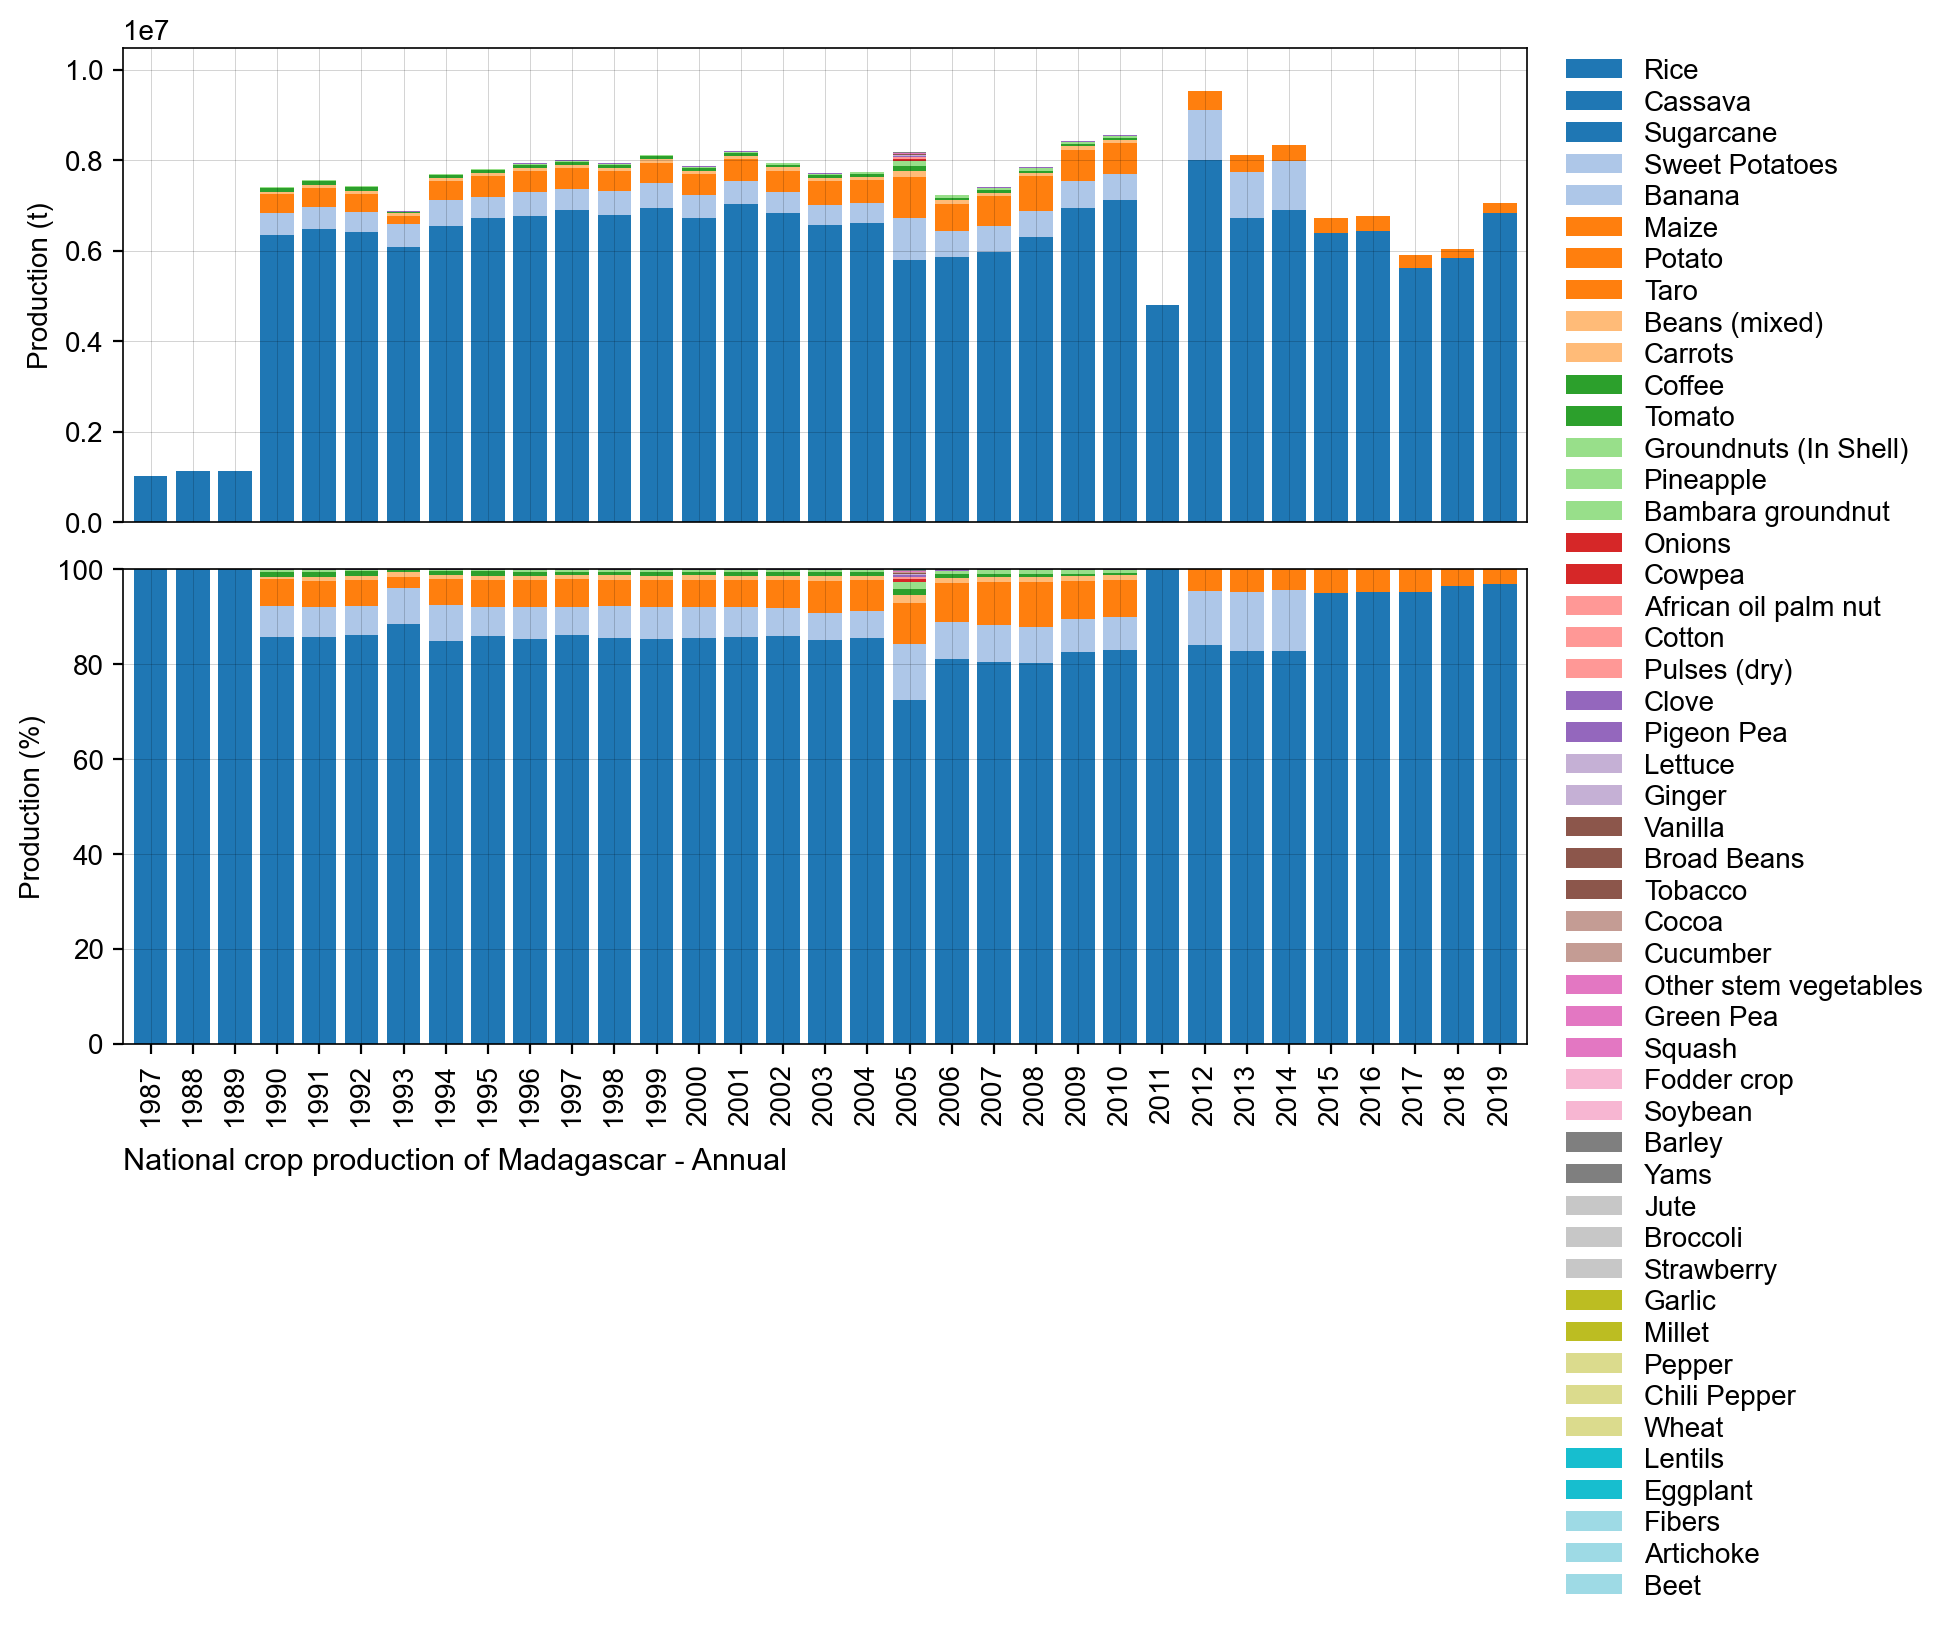

../figures/MG_bar_natgrainprod_Annual.png is saved.


In [8]:
# Bar chart of national crop production
country_iso, country_name = 'MG', 'Madagascar'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Annual']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

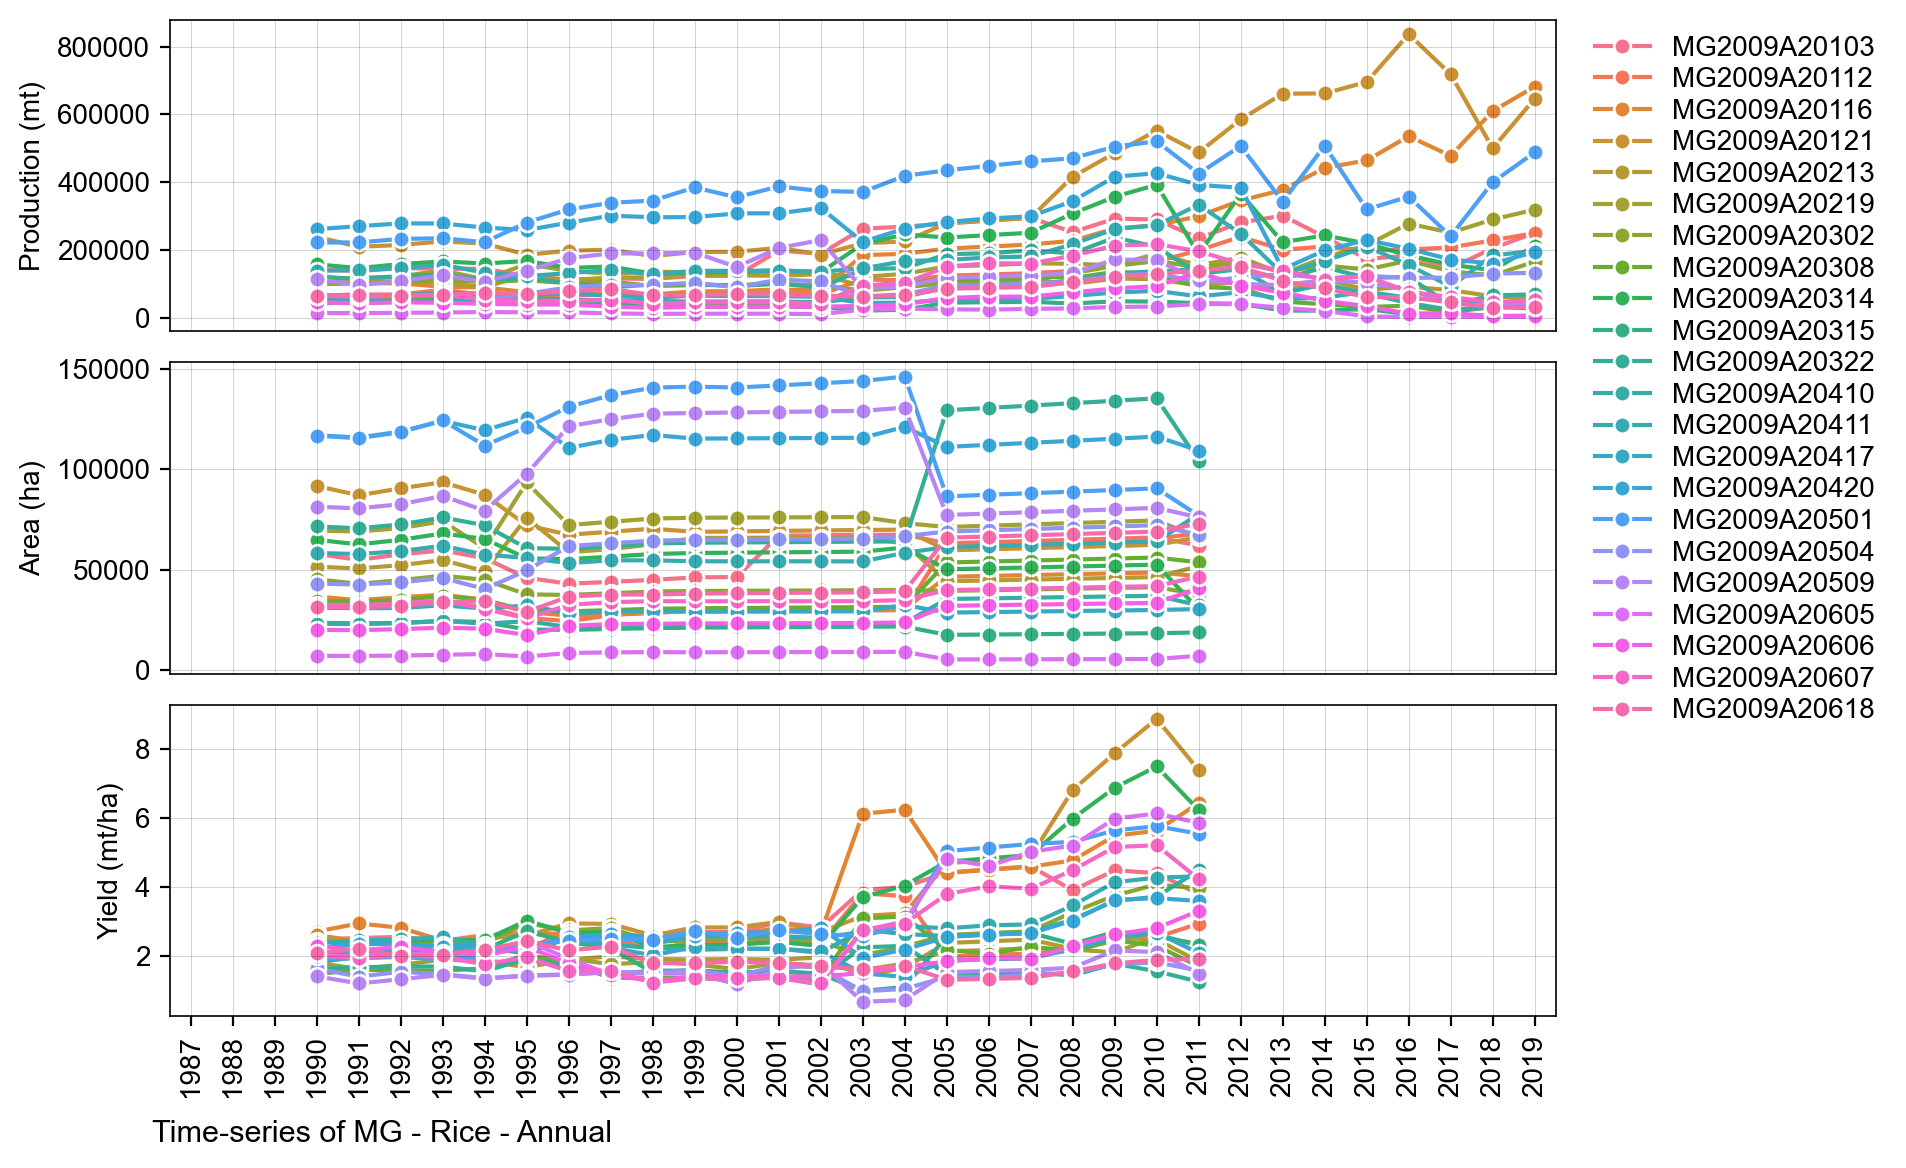

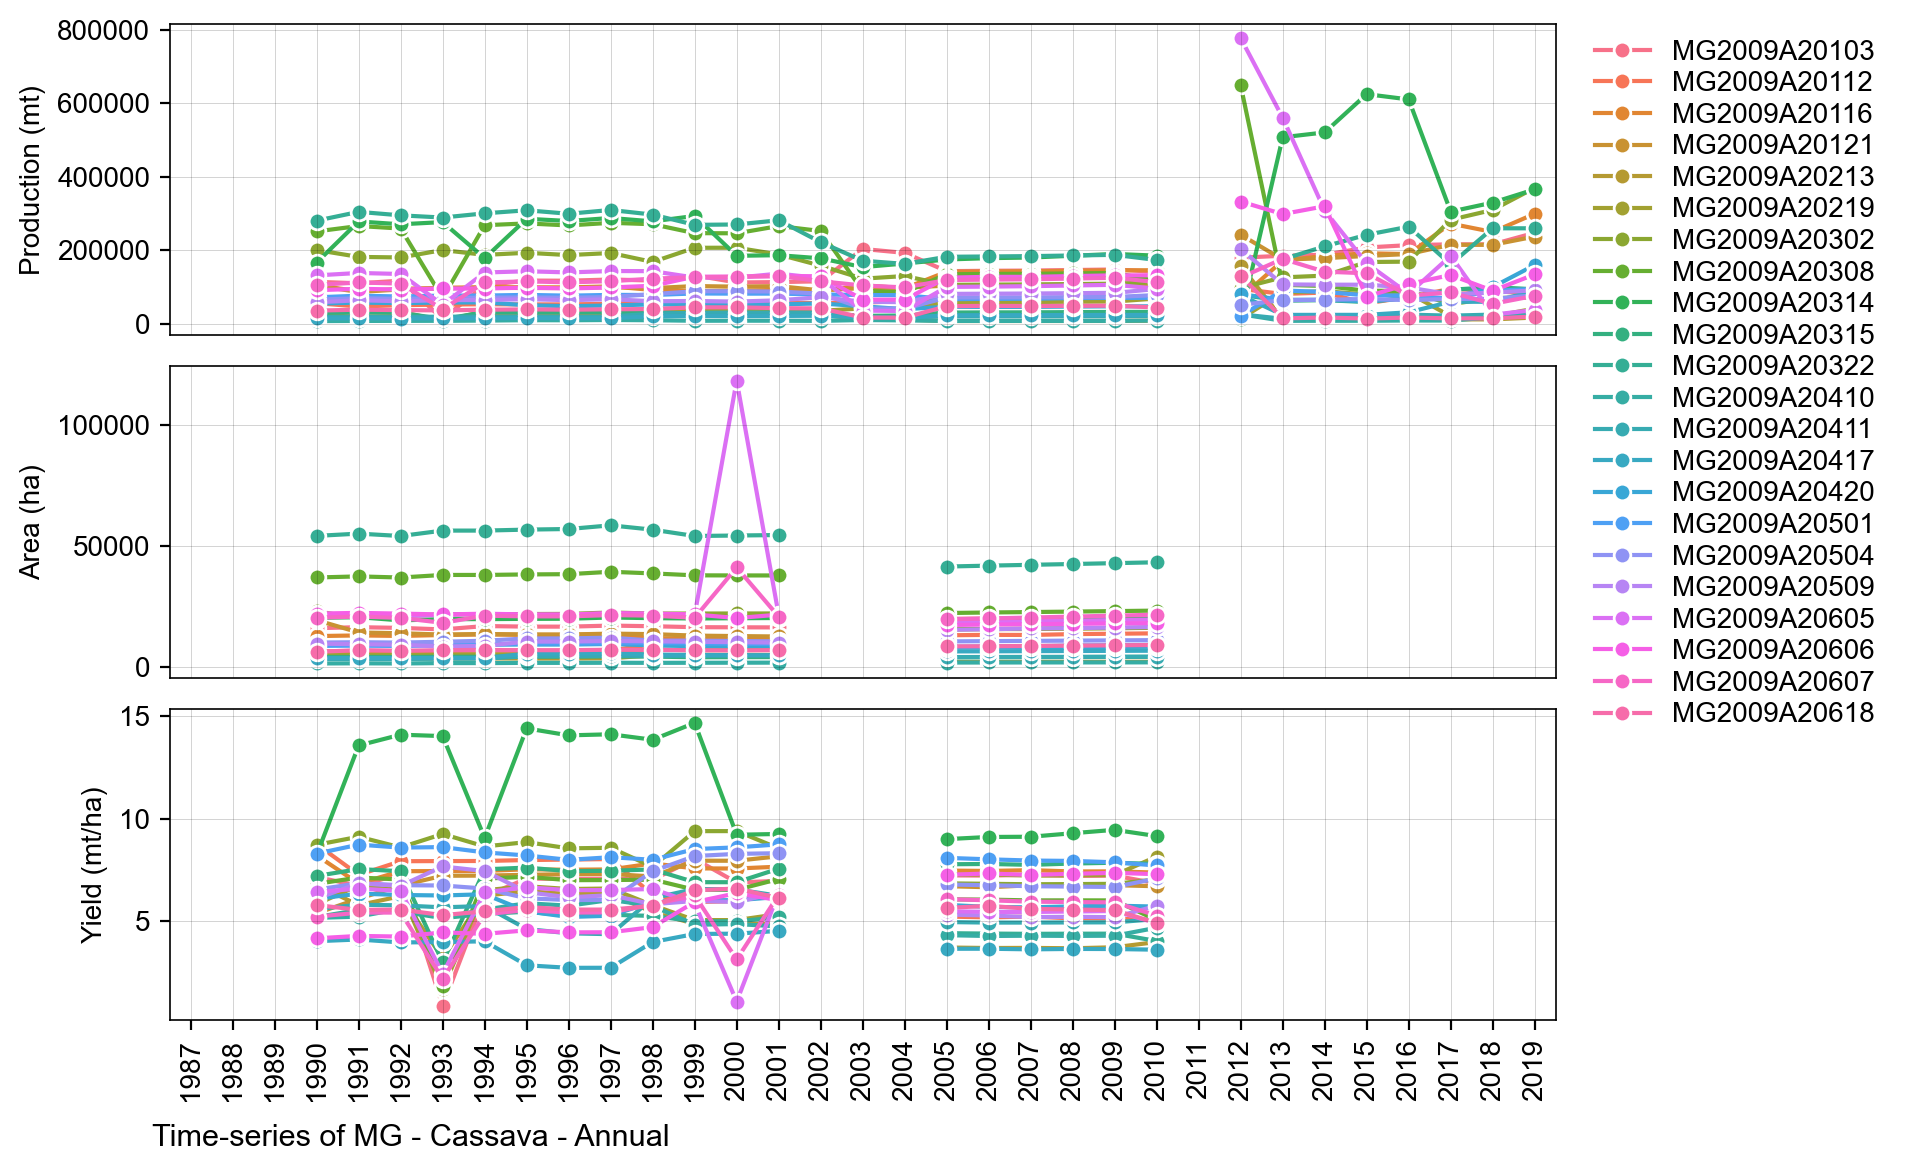

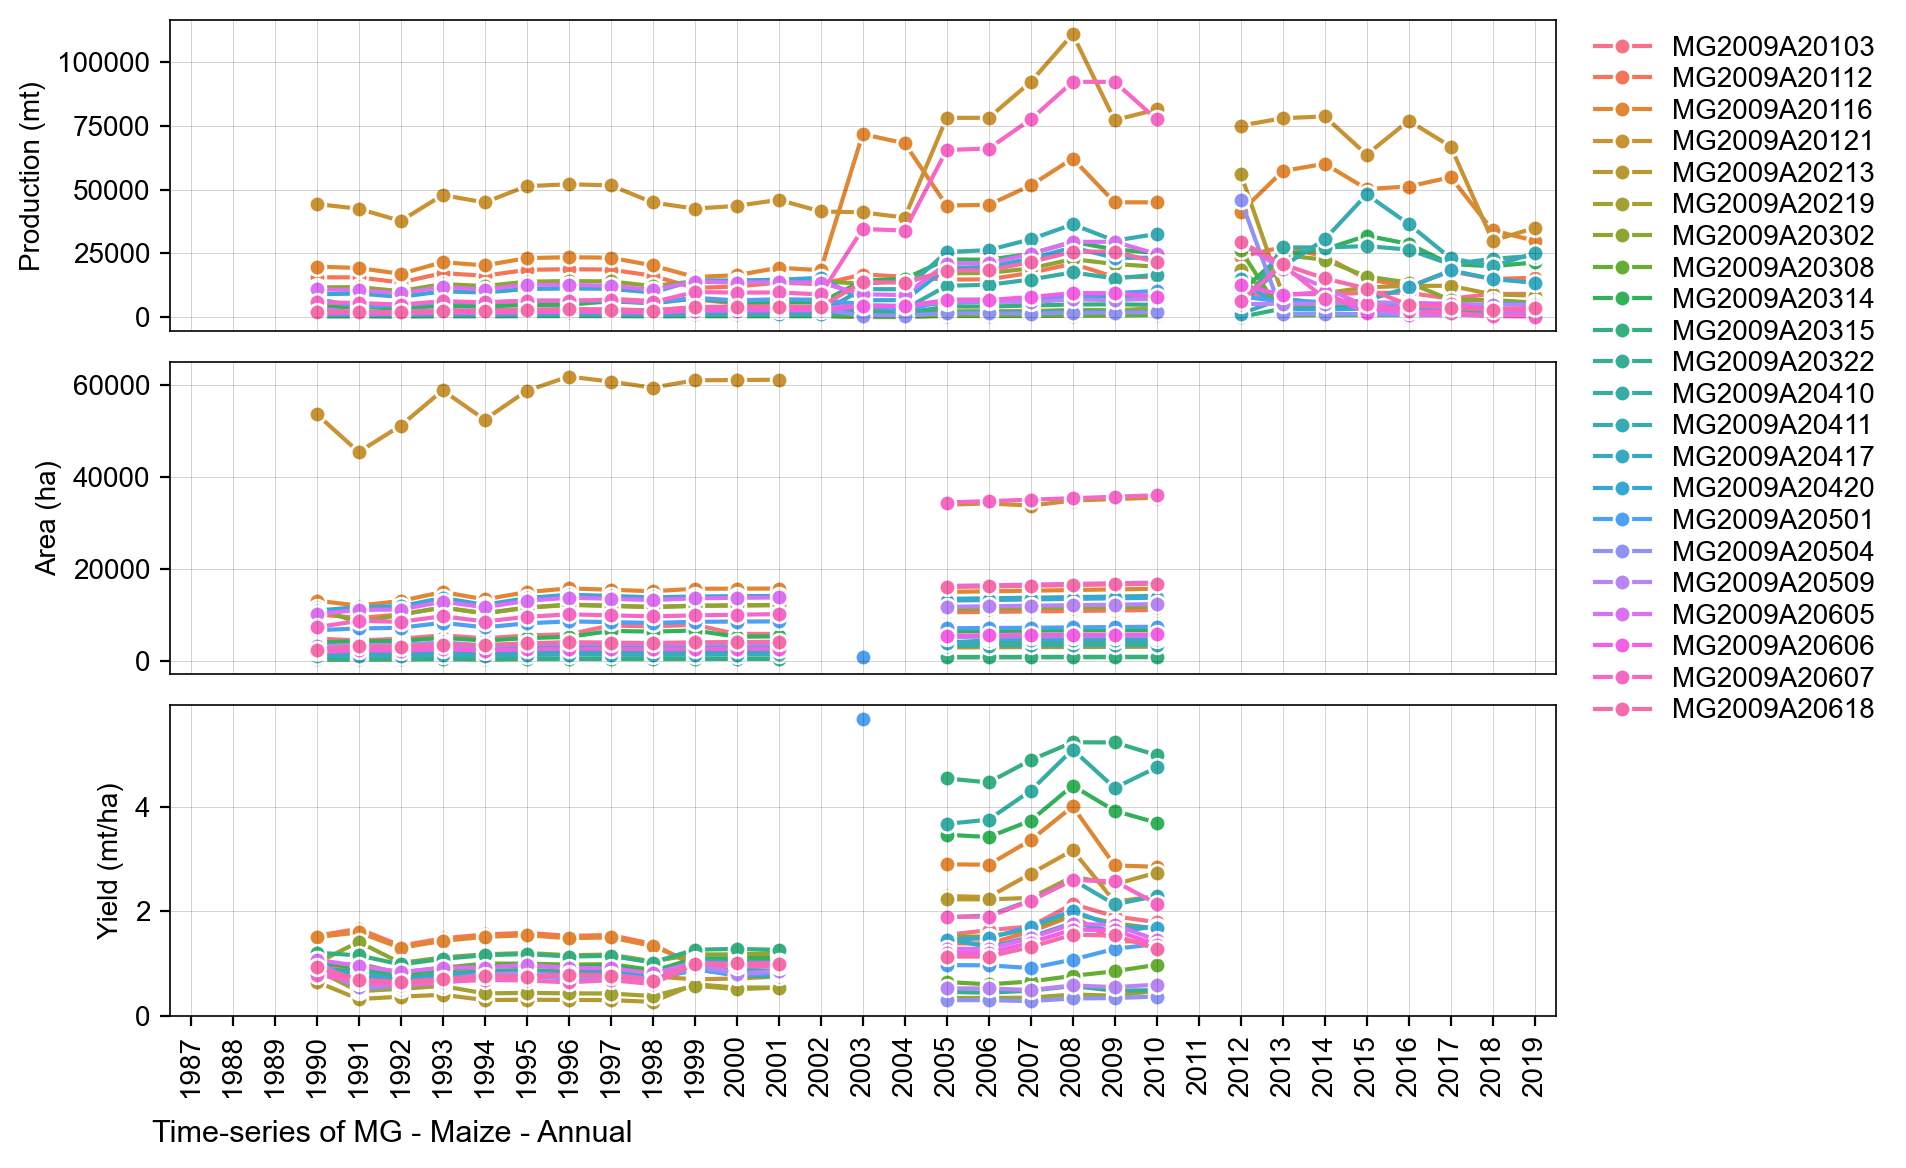

In [9]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'MG', 'Madagascar'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Rice','Annual'],
    ['Cassava','Annual'],
    ['Maize','Annual'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)